In [9]:
import pandas as pd
import h5py
import torch
import numpy as np
from numpy import mean
import matplotlib.pyplot as plt

figure x

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
df = pd.read_csv('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/hsi_tensors/master.csv')
df = df.drop(['Unnamed: 0.1'], axis=1)
df = df.drop_duplicates()
df = df.drop(index=36)
df.dropna(subset=['taxonID_y'], inplace=True)
df['distance'] = df['distance'].astype(float)
df = df[df['taxonID_y'].map(df['taxonID_y'].value_counts()) >= 50]
# df_litu = df[df['taxonID_y'] == 'LITU']
df = df.loc[df.groupby('geometry')['distance'].idxmin()]
# df = pd.merge(df, df_litu, how='outer')
df = df[df['distance'] < 10]
df = df[df['taxonID_y'].map(df['taxonID_y'].value_counts()) >= 20]


# Define hyperparameters
batch_size = 32
learning_rate = 0.001
num_epochs = 200
taxonID_to_int = {taxonID: 0 if taxonID != 'LITU' else 1 for taxonID in df['taxonID_y'].unique()}
int_to_taxonID = {0: 'OTHER', 1: 'LITU'}
class ResizeToSize:
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, data):
        data = data.float()
        data = nn.functional.interpolate(data.unsqueeze(0).unsqueeze(0), size=self.target_size, mode='trilinear', align_corners=False)
        return data.squeeze(0).squeeze(0)

class CustomDataset(Dataset):
    def __init__(self, dataframe, target_size=(10, 10, 426), augment=True):
        self.dataframe = dataframe
        self.transform = ResizeToSize(target_size)
        self.augment = augment

        # Define augmentation transformations
        self.augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(degrees=90),
        ])

    def __len__(self):
        return len(self.dataframe)

    def min_max_scale(self, data):
        # Perform min-max scaling on the data
        min_val = data.min()
        max_val = data.max()
        scaled_data = (data - min_val) / (max_val - min_val)
        return scaled_data

    def zscore_scale(self, data):
        # Perform z-score scaling on the data
        mean = data.mean()
        std = data.std()
        scaled_data = (data - mean) / std
        return scaled_data
    
    def zeroaware_scale(self, data):
        # Perform zero-aware scaling on the data
        nonzero_data = data[data != 0]
        mean = nonzero_data.mean()
        std = nonzero_data.std()
        scaled_data = data.clone()
        scaled_data[scaled_data != 0] = (nonzero_data - mean) / std
        np.clip(scaled_data, -1, 1)
        return scaled_data

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_name = f"/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/hsi_tensors/{row['siteID']}_{row['date']}_{row['adjEasting']}_{row['adjNorthing']}.h5"
        
        # Open the h5 file
        file = h5py.File(img_name, 'r')
        data = torch.from_numpy(file['subset'][:])
        file.close()

        # Apply resizing to the data
        data = self.transform(data)

        # Perform min-max scaling on the data
        # data = self.min_max_scale(data)

        # Swap the channel and x dimensions
        data = data.permute(2, 1, 0)

        if row['taxonID_y'] not in taxonID_to_int:
            label = torch.tensor(0)

        label = torch.tensor(taxonID_to_int[row['taxonID_y']])

        # Apply augmentation if enabled
        if self.augment:
            data = self.augmentation(data)
        return data, label.float()

dataset = CustomDataset(df)

In [11]:
band_dict_pos = {i: [] for i in range(426)}
band_dict_neg = {i: [] for i in range(426)}

final_band_dict_pos = {i: 0 for i in range(426)}
final_band_dict_neg = {i: 0 for i in range(426)}

std_dict_pos = {i: 0 for i in range(426)}
std_dict_neg = {i: 0 for i in range(426)}



for data in dataset:
    for band in range(426):
        band_avg = float(torch.mean(data[0][band,:,:]).detach().numpy())
        if data[1] == 1:
            band_dict_pos[band] += [band_avg]
        else:
            band_dict_neg[band] += [band_avg]

for band in range(426):
    final_band_dict_pos[band] = sum(band_dict_pos[band])/len(band_dict_pos[band])
    final_band_dict_neg[band] = sum(band_dict_neg[band])/len(band_dict_neg[band])
    std_dict_pos[band] = np.std(band_dict_pos[band])
    std_dict_neg[band] = np.std(band_dict_neg[band])

In [8]:
df = pd.read_csv('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/hsi_tensors/master.csv')
df_positive = df[df['taxonID_y'] == 'LITU']
df_negative = df[df['taxonID_y'] != 'LITU']
band_dict_pos = {i: 0 for i in range(426)}

for row in df_positive.iterrows():
    print(row[1])
    file = row[1]['file']
    file = f'/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/hsi_tensors/{file}'
    file = h5py.File(file, 'r')
    data = file['subset'][:]
    file.close()
    for band in range(426):
        band_avg = mean(data[:,:, band])
        band_dict_pos[band] += band_avg
    
    for band in range(426):
        band_dict_pos[band] = band_dict_pos[band]/len(df_positive)


band_dict_neg = {i: 0 for i in range(426)}
for row in df_negative.iterrows():
    file = row[1]['file']
    file = f'/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/unknown_hsi_tensors/{file}'
    file = h5py.File(file, 'r')
    data = file['subset'][:]
    file.close()
    for band in range(426):
        band_avg = mean(data[:,:, band])
        band_dict_neg[band] += band_avg
    
    for band in range(426):
        band_dict_neg[band] = band_dict_neg[band]/len(df_negative)
    
    

Unnamed: 0.1                             10.0
xmin                                   4174.0
ymin                                   5902.0
xmax                                   4224.0
ymax                                   5956.0
                                  ...        
otherTagOrg                               NaN
samplingProtocolVersion     NEON.DOC.000987vD
identificationReferences                  NaN
morphospeciesID                           NaN
morphospeciesIDRemarks                    NaN
Name: 47, Length: 135, dtype: object


KeyError: 'file'

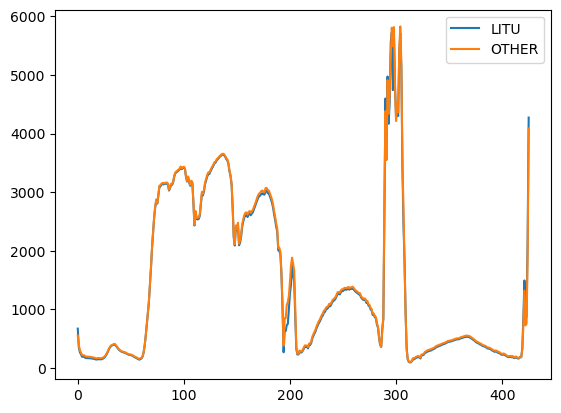

In [ ]:
x1 = []
y1 = []
x2 = []
y2 = []
for band in final_band_dict_pos:
    x1.append(band)
    y1.append(final_band_dict_pos[band])
    x2.append(band)
    y2.append(final_band_dict_neg[band])

plt.plot(x1, y1)
plt.plot(x2, y2)
plt.legend(['LITU', 'OTHER'])
plt.yscale('log')

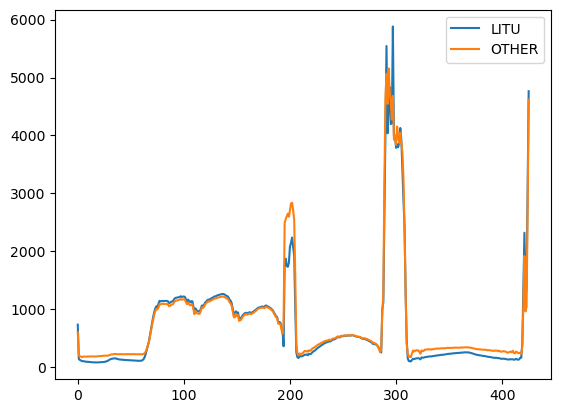

In [27]:
x1 = []
y1 = []
x2 = []
y2 = []
for band in std_dict_pos:
    x1.append(band)
    y1.append(std_dict_pos[band])
    x2.append(band)
    y2.append(std_dict_neg[band])

plt.plot(x1, y1)
plt.plot(x2, y2)
plt.legend(['LITU', 'OTHER'])

In [29]:
np.mean(y2)

789.6835890892605

figure x


In [33]:
sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_275000_3951000_image.tif"
from deepforest import main
from deepforest import get_data
from deepforest import utilities
import matplotlib.pyplot as plt
import rasterio
import rasterio.features
import rasterio.warp
import os
model = main.deepforest()
model.use_release()

Reading config file: /home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [31]:

model = main.deepforest()
model.use_release()

sample_image = get_data(sample_image_path)

img = model.predict_tile(sample_image, return_plot = True, patch_size=500,patch_overlap=0.25)
plt.imsave(f"figure.png", img[:,:,::-1])

Reading config file: /home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:15<00:00, 46.51it/s]
35618 predictions in overlapping windows, applying non-max supression
20543 predictions kept after non-max suppression


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/visualize.py:118: UserWarning: Input images must be channels last format [h, w, 3] not channels first [3, h, w], using np.rollaxis(image, 0, 3) to invert!
  warnings.warn("Input images must be channels last format [h, w, 3] not channels "
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/visualize.py:126: UserWarning: No color was provided and the label column is not numeric. Using a single default color.
  warnings.warn("No color was provided and the label column is not numeric. "


In [34]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

phenogeo_csv = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/phenogeo.csv"
df = pd.read_csv(phenogeo_csv)
df = pd.read_csv(phenogeo_csv).dropna(subset=['adjNorthing', 'adjEasting', 'uid'])
df = df.drop_duplicates(subset='uid')
df.reset_index(drop=True, inplace=True)

/tmp/ipykernel_1911725/2834813491.py:8: DtypeWarning: Columns (0,1,2,3,4,7,11,13,21,22,24,25,27,28,29,31,32,33,34,35,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,57,58,59,60,61,64,68,70,78,79,80,81,82,83,84,85,86,88,89,90,91,93,94,99,107,111,112,113,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(phenogeo_csv)
/tmp/ipykernel_1911725/2834813491.py:9: DtypeWarning: Columns (0,1,2,3,4,7,11,13,21,22,24,25,27,28,29,31,32,33,34,35,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,57,58,59,60,61,64,68,70,78,79,80,81,82,83,84,85,86,88,89,90,91,93,94,99,107,111,112,113,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(phenogeo_csv).dropna(subset=['adjNorthing', 'adjEasting', 'uid'])


In [37]:
from image import Image
img = Image(sample_image_path)

Reading config file: /home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


In [38]:
img.get_hsi_points()
img.annotate(df, threshold=10000)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:13<00:00, 52.20it/s]
35618 predictions in overlapping windows, applying non-max supression
20543 predictions kept after non-max suppression


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/utilities.py:476: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be "


True

In [39]:
from shapely.geometry import box
from pyproj import Transformer
import numpy as np
from scipy.spatial.distance import cdist
import numpy as np
import math 
meta_list = []
# Convert the centroid coordinates to a numpy array
centroid_array = np.array(list(zip(img.gdf.geometry.centroid.y, img.gdf.geometry.centroid.x)))

# Filter df to only include rows within utm coordinates of the image
utm_zone = img.gdf.crs.coordinate_operation.name[-3:]
df = df[df['utmZone'] == utm_zone]
df = df[(df['adjNorthing'] >= img.gdf.total_bounds[1]) & (df['adjNorthing'] <= img.gdf.total_bounds[3])]
df = df[(df['adjEasting'] >= img.gdf.total_bounds[0]) & (df['adjEasting'] <= img.gdf.total_bounds[2])]

for index, row in df.iterrows():
    ground_truth_utm = pd.to_numeric(row[['adjNorthing', 'adjEasting']].values).reshape(1, -1)
    print(ground_truth_utm)
    distances = cdist(ground_truth_utm, centroid_array)
    distance = min(distances[0, :])

    closest_indices = np.argmin(distances, axis=1)
    print(closest_indices[0])

    best_rgb_box = img.gdf.iloc[closest_indices[0]]

    print(f"Centroid of bounding box = {best_rgb_box['geometry'].centroid}")
    print(f"Ground truth = {ground_truth_utm[0]}")
    print(f"Distance to closest point = {min(distances[0,:])}")
    print("")

    
    # Create a new box for hsi conversion
    best_hsi_box = best_rgb_box.copy()
    best_hsi_box['xmin'] = math.floor(best_rgb_box['xmin']/10)
    best_hsi_box['ymin'] = math.floor(best_rgb_box['ymin']/10)
    best_hsi_box['xmax'] = math.ceil(best_rgb_box['xmax']/10)
    best_hsi_box['ymax'] = math.ceil(best_rgb_box['ymax']/10)
    
    meta_list.append({'distance': min(distances[0,:]),
                      'phenogeo': row.to_frame().T,
                      'rgb': best_rgb_box.to_frame().T,
                      'hsi': best_hsi_box.to_frame().T})
meta = pd.DataFrame(meta_list)

[[3951197.62662057  275346.05111337]]
2103
Centroid of bounding box = POINT (275348.1 3951202.4499999997)
Ground truth = [3951197.62662057  275346.05111337]
Distance to closest point = 5.2405081367435615

[[3951196.26419073  275350.37129449]]
2103
Centroid of bounding box = POINT (275348.1 3951202.4499999997)
Ground truth = [3951196.26419073  275350.37129449]
Distance to closest point = 6.589614176007224

[[3951192.41335473  275356.79978344]]
3552
Centroid of bounding box = POINT (275357.65 3951192.6)
Ground truth = [3951192.41335473  275356.79978344]
Distance to closest point = 0.870462320148291

[[3951195.81565336  275356.17221163]]
3552
Centroid of bounding box = POINT (275357.65 3951192.6)
Ground truth = [3951195.81565336  275356.17221163]
Distance to closest point = 3.5389666554891983

[[3951207.1157554   275362.26485076]]
5072
Centroid of bounding box = POINT (275366.4 3951203.7)
Ground truth = [3951207.1157554   275362.26485076]
Distance to closest point = 5.363473148461733

[[3

In [40]:
best_index = meta['distance'].idxmin()
rgb_points = meta['rgb'][best_index][['xmin', 'ymin', 'xmax', 'ymax']].values[0]
hsi_points = meta['hsi'][best_index][['xmin', 'ymin', 'xmax', 'ymax']].values[0]

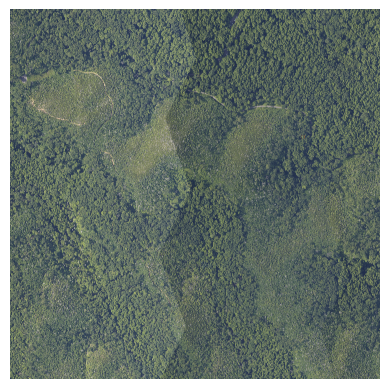

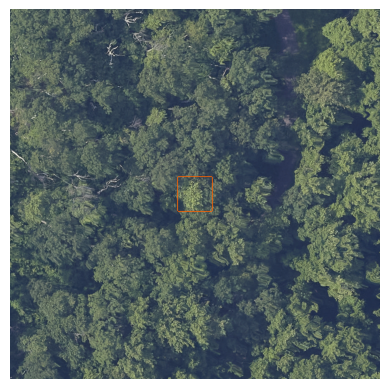

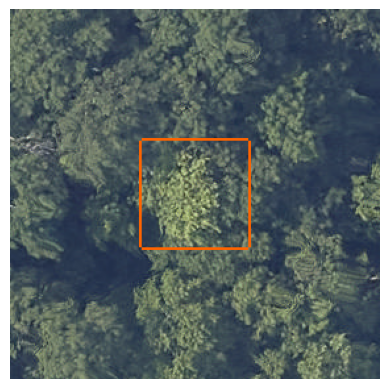

In [46]:
rgb_img = img.data.copy().transpose(1,2,0)

rgb_points = [int(x) for x in rgb_points]
larger_bounds = [int(rgb_points[0]-100), int(rgb_points[1]-100), int(rgb_points[2]+100), int(rgb_points[3]+100)]

rgb_img[rgb_points[0]-2:rgb_points[0], rgb_points[1]:rgb_points[3], :] = [255, 100, 0]
rgb_img[rgb_points[2]:rgb_points[2]+2, rgb_points[1]:rgb_points[3], :] = [255, 100, 0]
rgb_img[rgb_points[0]:rgb_points[2], rgb_points[1]-2:rgb_points[1], :] = [255, 100, 0]
rgb_img[rgb_points[0]:rgb_points[2], rgb_points[3]:rgb_points[3]+2, :] = [255, 100, 0]

# rgb_img[larger_bounds[0]-10:larger_bounds[0], larger_bounds[1]:larger_bounds[3], :] = [255, 100, 0]
# rgb_img[larger_bounds[2]:larger_bounds[2]+10, larger_bounds[1]:larger_bounds[3], :] = [255, 100, 0]
# rgb_img[larger_bounds[0]:larger_bounds[2], larger_bounds[1]-10:larger_bounds[1], :] = [255, 100, 0]
# rgb_img[larger_bounds[0]:larger_bounds[2], larger_bounds[3]:larger_bounds[3]+10, :] = [255, 100, 0]


plt.imshow(rgb_img)
plt.axis('off')
plt.show()

plt.imshow(rgb_img[max(0,int(rgb_points[0]-400)):int(rgb_points[2]+400), max(0,int(rgb_points[1]-400)):int(rgb_points[3]+400), :])
plt.axis('off')
plt.show()

plt.imshow(rgb_img[int(rgb_points[0]-100):int(rgb_points[2]+100), int(rgb_points[1]-100):int(rgb_points[3]+100), :])
plt.axis('off')
plt.show()

In [47]:
sample_HSI_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/hsi/NEON_D07_GRSM_DP3_275000_3951000_reflectance.h5"
f = h5py.File(sample_HSI_path, 'r')
reflectance_data =f['GRSM']['Reflectance']['Reflectance_Data'][:]
reflectance_data = np.rot90(reflectance_data, k=2, axes=(0,1))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


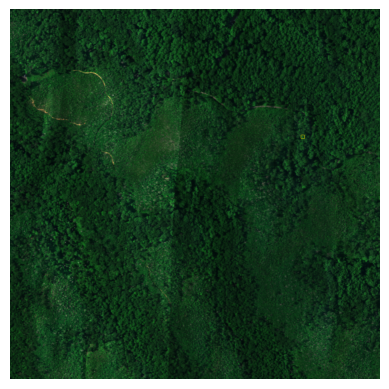

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


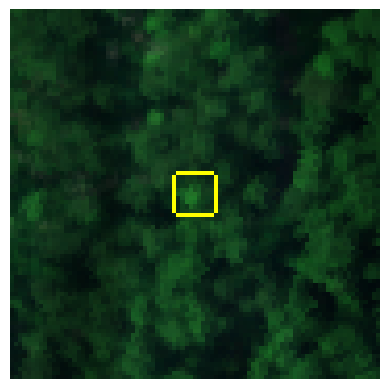

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


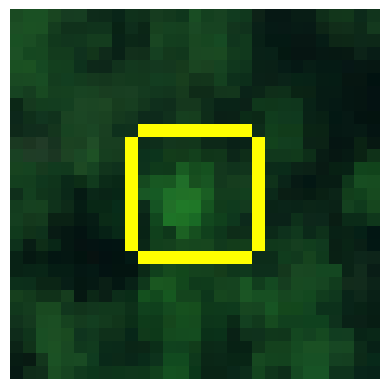

In [48]:
hsi_img = reflectance_data.copy()[:,:,[58, 34, 19]]
hsi_img = hsi_img / hsi_img.max()
hsi_points = [int(x) for x in hsi_points]
larger_bounds = [int(hsi_points[0])-10, int(hsi_points[1])-10, int(hsi_points[2])+10, int(hsi_points[3])+10]


hsi_img[hsi_points[0]-1:hsi_points[0], hsi_points[1]:hsi_points[3], :] = [255, 100, 0]
hsi_img[hsi_points[2]:hsi_points[2]+1, hsi_points[1]:hsi_points[3], :] = [255, 100, 0]
hsi_img[hsi_points[0]:hsi_points[2], hsi_points[1]-1:hsi_points[1], :] = [255, 100, 0]
hsi_img[hsi_points[0]:hsi_points[2], hsi_points[3]:hsi_points[3]+1, :] = [255, 100, 0]

# hsi_img[larger_bounds[0]-1:larger_bounds[0], larger_bounds[1]:larger_bounds[3], :] = [255, 100, 0]
# hsi_img[larger_bounds[2]:larger_bounds[2]+1, larger_bounds[1]:larger_bounds[3], :] = [255, 100, 0]
# hsi_img[larger_bounds[0]:larger_bounds[2], larger_bounds[1]-1:larger_bounds[1], :] = [255, 100, 0]
# hsi_img[larger_bounds[0]:larger_bounds[2], larger_bounds[3]:larger_bounds[3]+1, :] = [255, 100, 0]




plt.imshow(hsi_img)
plt.axis('off')
plt.show()

plt.imshow(hsi_img[max(0,int(hsi_points[0]-40)):int(hsi_points[2]+40), max(0,int(hsi_points[1]-40)):int(hsi_points[3]+40), :])
plt.axis('off')
plt.show()

plt.imshow(hsi_img[int(hsi_points[0]-10):int(hsi_points[2]+10), int(hsi_points[1]-10):int(hsi_points[3]+10), :])
plt.axis('off')
plt.show()


final fig

In [1]:
sample_image_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/rgb_test/2021_GRSM_5_275000_3951000_image.tif"
phenogeo_csv = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/phenogeo.csv"
from deepforest import main
from deepforest import get_data
from deepforest import utilities
import matplotlib.pyplot as plt
import rasterio
import rasterio.features
import rasterio.warp
import os
import pandas as pd
from image import Image
import numpy as np
model = main.deepforest()
model.use_release()

img = Image(sample_image_path)
df = pd.read_csv(phenogeo_csv)

/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Reading config file: /home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0
Reading config file: /home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/data/deepforest_config.yml


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


No validation file provided. Turning off validation loop
Model from DeepForest release https://github.com/weecology/DeepForest/releases/tag/1.0.0 was already downloaded. Loading model from file.
Loading pre-built model: https://github.com/weecology/DeepForest/releases/tag/1.0.0


/tmp/ipykernel_4625/1978814301.py:18: DtypeWarning: Columns (0,1,2,3,4,7,11,13,21,22,24,25,27,28,29,31,32,33,34,35,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,57,58,59,60,61,64,68,70,78,79,80,81,82,83,84,85,86,88,89,90,91,93,94,99,107,111,112,113,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(phenogeo_csv)


In [2]:
sample_image = get_data(sample_image_path)

# plt.imsave(f"figure.png", img[:,:,::-1])

In [3]:
img.get_bounding_boxes(score_threshold=0)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:50<00:00, 14.46it/s]
35618 predictions in overlapping windows, applying non-max supression
20543 predictions kept after non-max suppression


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/utilities.py:476: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be "


In [4]:
def plot_trees(boxes):
    centroids = []
    for _, box in boxes.iterrows():
        centroid = box[0] + (box[2] - box[0])/2, box[1] + (box[3] - box[1])/2
        centroids.append(centroid)
    centroids = np.array(centroids)
    plt.scatter(centroids[:,1], centroids[:,0], c='r', s=.5, alpha=0.5)
    plt.imshow(img.data.transpose(1,2,0))


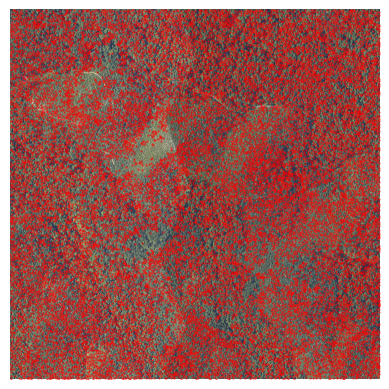

In [15]:
#swap to y,x,c
# plt.imshow(img.data.transpose(1,2,0))
import numpy as np
boxes = img.boxes.copy()
plot_trees(boxes)
plt.axis('off')
plt.savefig('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/figure_final1.png',bbox_inches='tight')

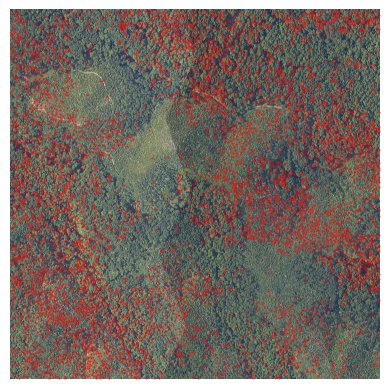

In [14]:
boxes_score = boxes[boxes['score']>0.5]
plot_trees(boxes_score)
plt.axis('off')
plt.savefig('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/figure_final2.png',bbox_inches='tight')

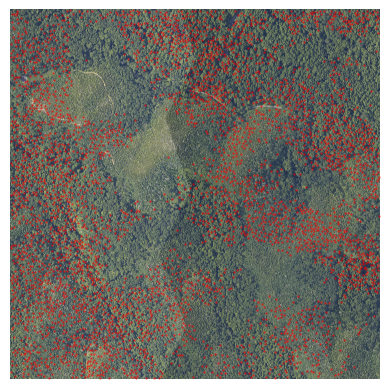

In [13]:
boxes_size = boxes_score[(boxes_score['xmax'] - boxes_score['xmin']) > 50]
boxes_size = boxes_size[(boxes_size['ymax'] - boxes_size['ymin']) > 50]
boxes_size = boxes_size[(boxes_size['xmax'] - boxes_size['xmin']) < 500]
boxes_size = boxes_size[(boxes_size['ymax'] - boxes_size['ymin']) < 500]
plot_trees(boxes_size)
plt.axis('off')
plt.savefig('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/figure_final3.png',bbox_inches='tight')

In [9]:
df = pd.read_csv('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/phenogeo.csv')
img.get_bounding_boxes()
img.annotate(df)

/tmp/ipykernel_4625/380864173.py:1: DtypeWarning: Columns (0,1,2,3,4,7,11,13,21,22,24,25,27,28,29,31,32,33,34,35,37,38,39,40,41,42,43,45,46,47,48,49,50,51,52,53,54,57,58,59,60,61,64,68,70,78,79,80,81,82,83,84,85,86,88,89,90,91,93,94,99,107,111,112,113,116,117) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/temp_data/phenogeo.csv')
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 729/729 [00:50<00:00, 14.51it/s]
35618 predictions in overlapping windows, applying non-max supression
20543 predictions kept after non-max suppression


/home/kmitchell/miniconda3/envs/micropheno/lib/python3.11/site-packages/deepforest/utilities.py:476: UserWarning: This method is deprecated and will be removed in version DeepForest 2.0.0, please use boxes_to_shapefile which unifies project_boxes and annotations_to_shapefile functionalities
  warnings.warn("This method is deprecated and will be "


wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo
wee woo


True

In [57]:
sample_HSI_path = "/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/input_data/hsi/NEON_D07_GRSM_DP3_275000_3951000_reflectance.h5"
for tree in img.generate_hsi_trees(sample_HSI_path):
    pass

(array([[[  932,   822,   572, ...,  1750,  3398, 12915],
        [ 1008,   564,   539, ...,   423,  1748, 12781],
        [  998,   558,   533, ...,   415,  1716, 12545],
        [ 1074,   671,   492, ...,   537,     0,  9025],
        [ 1327,   760,   544, ...,   202,  3322, 14963]],

       [[  978,   822,   553, ...,  2342,  5986,  6740],
        [ 1000,   561,   557, ...,   884,     0, 11870],
        [ 1068,   691,   509, ...,     0,  1109, 14427],
        [  950,   686,   469, ...,   894,  2605,   453],
        [  973,   703,   481, ...,   926,  2698,   469]],

       [[ 1206,   858,   561, ...,  1681,  4677, 12541],
        [ 1113,   755,   559, ...,     0,  4490, 12045],
        [  986,   728,   535, ...,     0,   528, 14959],
        [ 1271,   696,   510, ...,  1614,   663,  9580],
        [ 1149,   614,   542, ...,   950,  2776,  4240]],

       [[ 1072,   796,   577, ...,   398,  3501,  2725],
        [  959,   785,   529, ...,   564,  4466,  6524],
        [  896,   637,  

In [70]:
img.ground_truth_df

,xmin,ymin,xmax,ymax,label,score,image_path,geometry,xmin_hsi,ymin_hsi,...,stemAzimuth,recordType,supportingStemIndividualID,previouslyTaggedAs,otherTagID,otherTagOrg,samplingProtocolVersion,identificationReferences,morphospeciesID,morphospeciesIDRemarks
0,3473.0,7994.0,3509.0,8031.0,Tree,0.154813,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275350.950 3951200.550, 275350.950 3...",347,799,...,20.1,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN
1,3473.0,7994.0,3509.0,8031.0,Tree,0.154813,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275350.950 3951200.550, 275350.950 3...",347,799,...,47.3,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN
2,3512.0,8012.0,3640.0,8135.0,Tree,0.565888,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275364.050 3951198.750, 275364.050 3...",351,801,...,78.2,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN
3,3512.0,8012.0,3640.0,8135.0,Tree,0.565888,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275364.050 3951198.750, 275364.050 3...",351,801,...,64.4,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN
4,3605.0,7932.0,3639.0,7967.0,Tree,0.172887,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275363.950 3951206.750, 275363.950 3...",360,793,...,47.5,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN
5,3471.0,8039.0,3500.0,8089.0,Tree,0.490065,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275350.050 3951196.050, 275350.050 3...",347,803,...,61.9,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN
6,3424.0,8051.0,3464.0,8094.0,Tree,0.410638,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275346.450 3951194.850, 275346.450 3...",342,805,...,75.2,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN
7,3473.0,7994.0,3509.0,8031.0,Tree,0.154813,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275350.950 3951200.550, 275350.950 3...",347,799,...,55.6,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN
8,3570.0,7891.0,3623.0,7941.0,Tree,0.498088,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275362.350 3951210.850, 275362.350 3...",357,789,...,37.3,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN
9,3485.0,7927.0,3589.0,7999.0,Tree,0.641628,2021_GRSM_5_275000_3951000_image.tif,"POLYGON ((275358.950 3951207.250, 275358.950 3...",348,792,...,49.0,NaN,NaN,NaN,NaN,NaN,NEON.DOC.000987vE,NaN,NaN,NaN


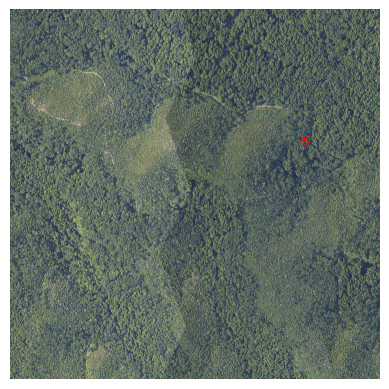

In [12]:
df = img.ground_truth_df.copy()

plot_trees(df)
plt.axis('off')
plt.savefig('/mnt/c/Users/kmitchell/Documents/GitHub/Thesis/figure_final4.png',bbox_inches='tight')